In [2]:
# Import required modules
import json
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Use ggplot
matplotlib.style.use('ggplot')

PROMPT_SHORT_DICT = {
    'cot': 'chain_of_thought',
    'sot': 'skeleton_of_thought',
    'sc': 'self_consistency',
    'gk': 'generated_knowledge',
    'ltm': 'least_to_most',
    'cov': 'chain_of_verification',
    'sbp': 'step_back_prompting',
    'rar': 'rephrase_and_respond',
    'em': 'emotion_prompt',
    'ds': 'directional_stimuli',
    'rcai': 'recursive_criticism_and_improvement',
    'rp': 'reverse_prompting',
}

# Function to format the full name
def format_full_name(name):
    words = name.split('_')
    formatted_words = []
    for word in words:
        if word in ['and', 'of', 'to']:
            formatted_words.append(word)
        else:
            formatted_words.append(word.capitalize())
    return ' '.join(formatted_words)

# Load JSON data into a dictionary
with open('../4_response_extraction/results_dataframe.json', 'r') as file:
    data = json.load(file)

# Convert dictionary to DataFrame
df = pd.DataFrame(data)
df.head()

,model,prompt_method,prompt_template,prompt_short,sample_size,org_folder,file_path,extracted_rows,extracted_data_len,failed_to_capture,regex_counts
0,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.301, 35.0, 1.87, 3.3, 5.12e+20, 5...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
1,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.485, 30.0, 2.36, 3.3, 6.38e+20, 7...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
2,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[aluminium, 0.85, 45.0, 3.2, 3.3, 7.2e+20, 89...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
3,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.3, 35.0, 1.8, 3.3, 5.2e+20, 51000...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."
4,claude-3-5-sonnet-20240620,chain_of_thought,1prompt_templates_system_stats.json,cot,rs_size_5,d_clean_remove_small_samples_ipr,./../3_llm_generation/outputs/claude-3-5-sonne...,"[[plastic, 0.3, 35.0, 1.8, 3.3, 5.2e+20, 51000...",25,,"{'multi_pattern': 25, 'list_new_pattern': 25, ..."


In [3]:
# All models grouped together so 12 models x 15 responses per combination = 180
df_grp_prompt_ss= df.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].count().reset_index()
df_grp_prompt_ss

,prompt_method,sample_size,extracted_data_len
0,chain_of_thought,rs_size_10,180
1,chain_of_thought,rs_size_100,180
2,chain_of_thought,rs_size_150,180
3,chain_of_thought,rs_size_25,165
4,chain_of_thought,rs_size_5,165
...,...,...,...
67,step_back_prompting,rs_size_100,180
68,step_back_prompting,rs_size_150,180
69,step_back_prompting,rs_size_25,180
70,step_back_prompting,rs_size_5,180


In [4]:
# Custom aggregation function to sum dictionary values
def sum_dicts(series):
    result = {}
    for d in series:
        for key, val in d.items():
            if key in result:
                result[key] += val
            else:
                result[key] = val
    return result

# Group by 'model' and aggregate using custom function
result = df.groupby('model')['regex_counts'].agg(sum_dicts).reset_index()

regex_cols = ['multi_pattern', 'list_new_pattern', 'dict_pattern', 
              'row_list_pattern', 'row_key_value_space_pattern', 'dict_equal_val_key_pattern']

# Initialize a new DataFrame
df_regex = pd.DataFrame(columns=['model'] + regex_cols)

# Populate the new DataFrame
rows_list = []
for index, row in result.iterrows():
    # Start by setting the model
    new_row = {'model': row['model']}
    
    # Retrieve the regex_counts dictionary from the result DataFrame
    regex_counts = row['regex_counts']
    
    # Loop through each expected regex column to set its value
    for col in regex_cols:
        new_row[col] = regex_counts.get(col, 0)  # Use .get to avoid KeyError if key is missing
    
    # Add new_row to rows_list to append later
    rows_list.append(new_row)

# Create a DataFrame from rows_list and concatenate with the initial empty DataFrame
df_regex = pd.concat([df_regex, pd.DataFrame(rows_list)], ignore_index=True)

df_regex

,model,multi_pattern,list_new_pattern,dict_pattern,row_list_pattern,row_key_value_space_pattern,dict_equal_val_key_pattern
0,claude-3-5-sonnet-20240620,27590,27620,0,27606,0,0
1,claude-3-sonnet-20240229,25641,26593,0,25650,0,75
2,gemma:7b,1029,1362,823,1202,0,237
3,gpt-3.5-turbo-0125,24673,24924,0,24594,0,15
4,gpt-4o,27295,29143,0,24811,0,398
5,llama2:13b,4255,5797,646,4506,535,782
6,llama3:70b,18677,20352,4,12389,0,7204
7,llama3:8b,14571,15846,88,14155,31,498
8,mistral:7b,4584,6498,70,4670,1,477
9,mixtral:8x22b,20953,21663,164,20729,25,50


/tmp/ipykernel_54050/2772962.py:53: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([PROMPT_SHORT_DICT_REV.get(label.get_text(), label.get_text()).upper() for label in ax2.get_yticklabels()])
/tmp/ipykernel_54050/2772962.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


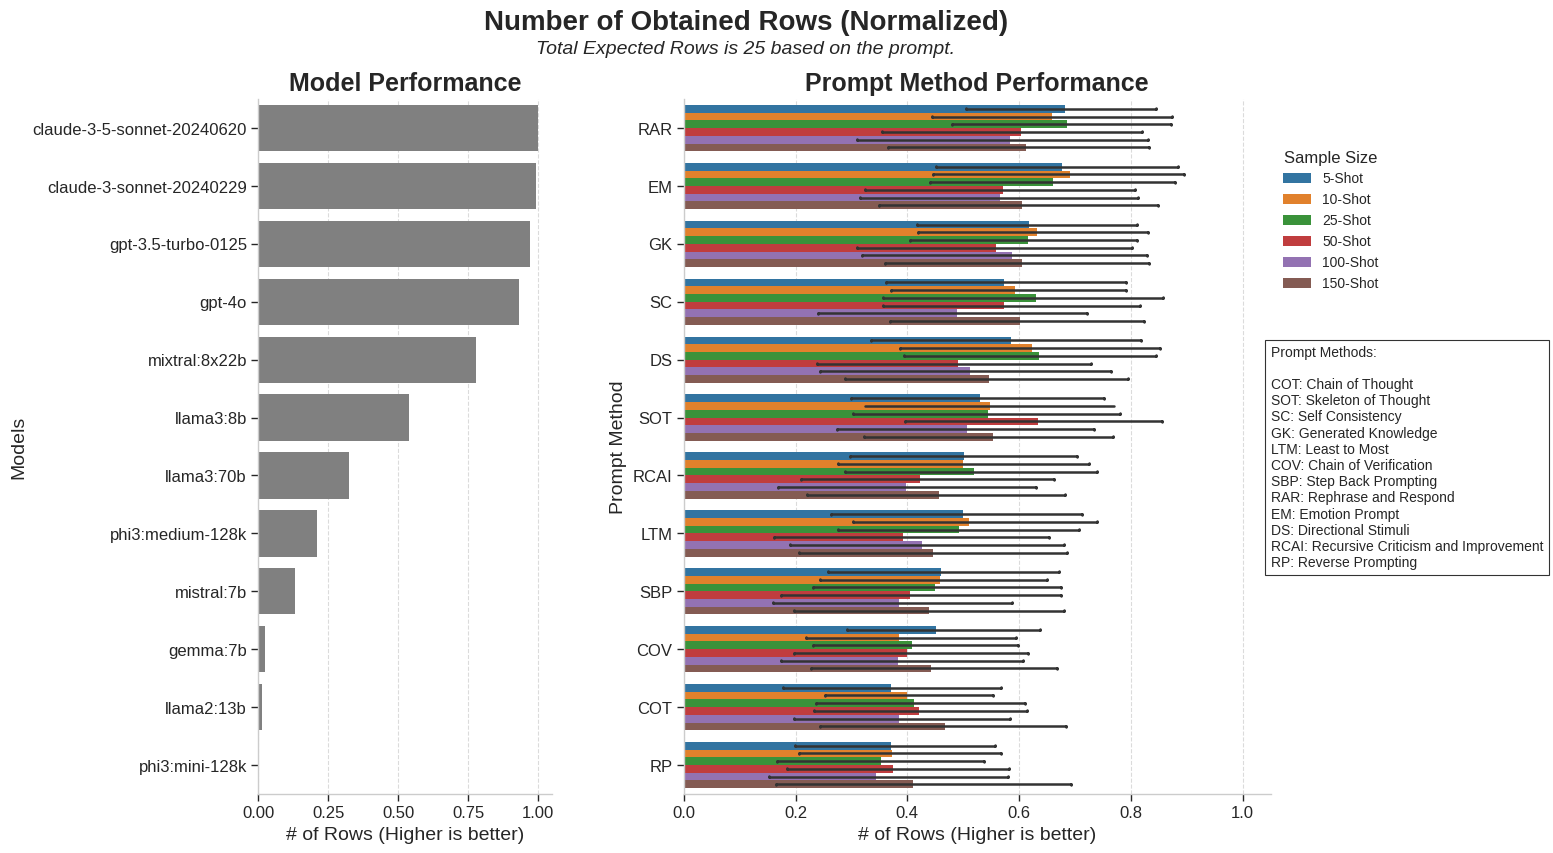

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is your DataFrame and all previous calculations are correct
# Calculating normalized expected row count
model_ex_row_norm = df.groupby(['model','prompt_method','sample_size'])['extracted_data_len'].sum() / (15 * 25)
df_model_ex_row_norm = model_ex_row_norm.reset_index()

# Group by model, calculate median and sort descending
model_ex_row_norm_median = model_ex_row_norm.groupby('model').median().sort_values(ascending=False).reset_index()

# Create a proper order for the 'sample_size' column
sample_size_order = ['rs_size_5', 'rs_size_10', 'rs_size_25', 'rs_size_50', 'rs_size_100', 'rs_size_150']

# Create a reverse dictionary for prompt methods
PROMPT_SHORT_DICT_REV = {v: k for k, v in PROMPT_SHORT_DICT.items()}

# Create a dictionary for sample size formatting
SAMPLE_SIZE_FORMAT = {f'rs_size_{size}': f'{size}-Shot' for size in [5, 10, 25, 50, 100, 150]}

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper")
sns.set_palette("tab10")

# Create a figure with two subplots and a text box
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [1, 2]})

# First subplot
sns.barplot(y='model', x='extracted_data_len', data=model_ex_row_norm_median, ax=ax1, 
            capsize=.2, edgecolor="none", color='grey', err_kws={'color': '.2'})
ax1.set_title('Model Performance', fontsize=18, fontweight='bold')
ax1.set_ylabel('Models', fontsize=14)
ax1.set_xlabel('# of Rows (Higher is better)', fontsize=14)
ax1.set_xlim([0, 1.05])
ax1.tick_params(axis='both', which='major', labelsize=12)

# Second subplot
# Order prompt methods by performance
prompt_order = df_model_ex_row_norm.groupby('prompt_method')['extracted_data_len'].mean().sort_values(ascending=False).index
sns.barplot(data=df_model_ex_row_norm, y='prompt_method', x='extracted_data_len', 
            hue='sample_size', hue_order=sample_size_order, ax=ax2, 
            order=prompt_order, capsize=.1, edgecolor="none", err_kws={'color': '.2'})
ax2.set_title('Prompt Method Performance', fontsize=18, fontweight='bold')
ax2.set_ylabel('Prompt Method', fontsize=14)
ax2.set_xlabel('# of Rows (Higher is better)', fontsize=14)
ax2.set_xlim([0, 1.05])
ax2.tick_params(axis='both', which='major', labelsize=12)

# Update y-axis labels with short-hand versions
ax2.set_yticklabels([PROMPT_SHORT_DICT_REV.get(label.get_text(), label.get_text()).upper() for label in ax2.get_yticklabels()])

# Remove top and right spines
for ax in [ax1, ax2]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Add a subtle grid
for ax in [ax1, ax2]:
    ax.grid(axis='x', linestyle='--', alpha=0.7, color='#CCCCCC')

# Create a third axes for the legends
ax3 = fig.add_axes([0.85, 0.1, 0.1, 0.8])
ax3.axis('off')

# Add sample size legend to ax3
handles, labels = ax2.get_legend_handles_labels()
formatted_labels = [SAMPLE_SIZE_FORMAT.get(label, label) for label in labels]
ax3.legend(handles, formatted_labels, title='Sample Size', loc='upper left', fontsize=10, title_fontsize=12)

# Add prompt method explanations to ax3
prompt_explanations = '\n'.join([f"{short.upper()}: {format_full_name(full)}" for short, full in PROMPT_SHORT_DICT.items()])
ax3.text(0, 0.5, 'Prompt Methods:\n\n' + prompt_explanations, 
         verticalalignment='center', horizontalalignment='left',
         fontsize=10, bbox=dict(facecolor='white', alpha=0.8, edgecolor='black'))

# Remove the legend from ax2
ax2.get_legend().remove()

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(right=0.85, wspace=0.3)  # Adjust right margin for the legends and space between subplots

# Add a general title for the entire figure
fig.suptitle('Number of Obtained Rows (Normalized)', fontsize=20, fontweight='bold', y=1.06)
# Add description below the title
fig.text(0.5, 1.01, "Total Expected Rows is 25 based on the prompt.", 
         ha='center', va='center', fontsize=14, style='italic')


plt.savefig('./images/model_overall_performance_vs_prompt_method_performance.jpg', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# 
model_successfully_gen_samples_median_norm = model_ex_row_norm.groupby('model').median().sort_values(ascending=False).reset_index()
model_successfully_gen_samples_median_norm.columns = ['model','successfully_generated_samples_median_normalized']
model_successfully_gen_samples_median_norm.to_csv('model_successfully_gen_samples_median_norm.csv')
model_successfully_gen_samples_median_norm

,model,successfully_generated_samples_median_normalized
0,claude-3-5-sonnet-20240620,1.000000
1,claude-3-sonnet-20240229,0.994667
2,gpt-3.5-turbo-0125,0.973333
3,gpt-4o,0.933333
4,mixtral:8x22b,0.780000
5,llama3:8b,0.537333
6,llama3:70b,0.322667
7,phi3:medium-128k,0.208000
8,mistral:7b,0.129333
9,gemma:7b,0.024000


In [15]:
prompt_order = df_model_ex_row_norm.groupby('prompt_method')['extracted_data_len'].mean().sort_values(ascending=False)
prompt_order.to_csv('prompt_method_successfully_gen_samples_mean_norm.csv')
prompt_order

prompt_method
rephrase_and_respond                   0.637778
emotion_prompt                         0.628185
generated_knowledge                    0.602778
self_consistency                       0.575962
directional_stimuli                    0.563014
skeleton_of_thought                    0.551619
recursive_criticism_and_improvement    0.466037
least_to_most                          0.460630
step_back_prompting                    0.432667
chain_of_verification                  0.411704
chain_of_thought                       0.409981
reverse_prompting                      0.371117
Name: extracted_data_len, dtype: float64

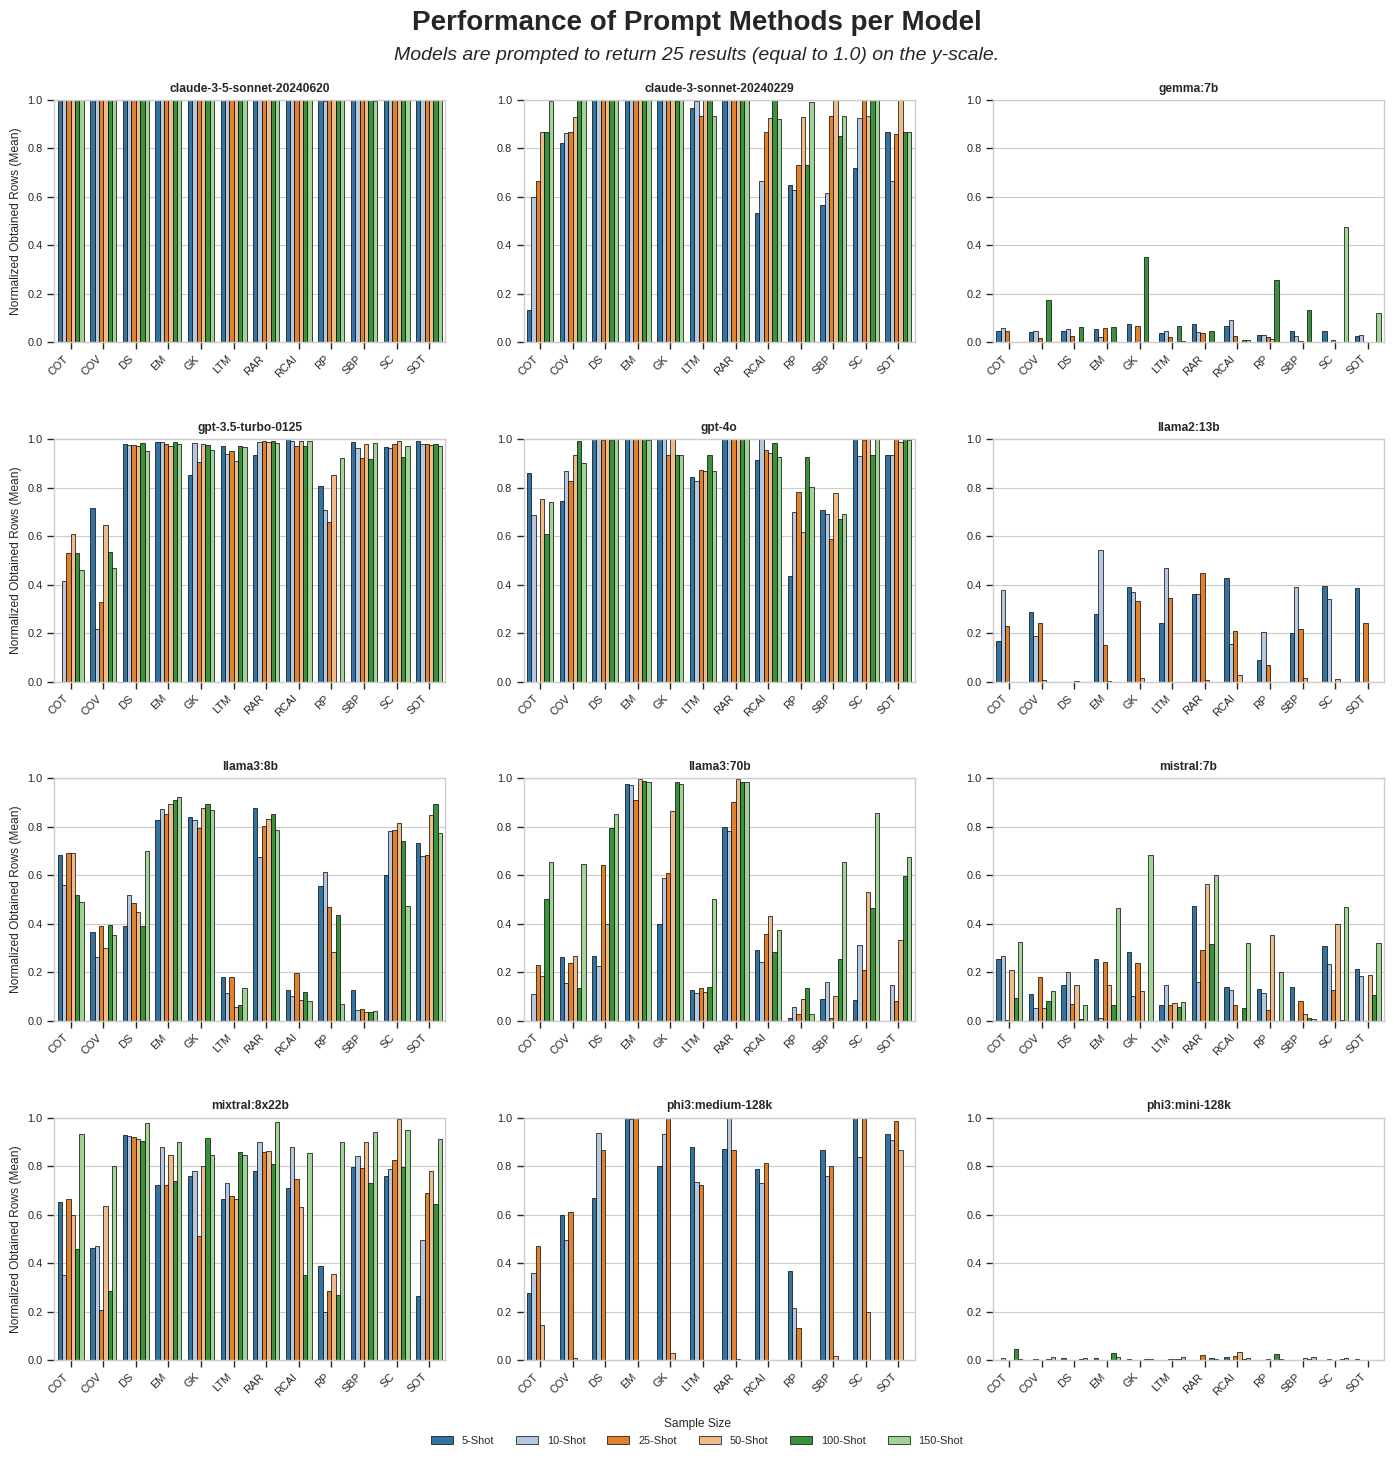

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming df is your DataFrame and all previous calculations are correct

# Identify unique models
unique_models = df['model'].unique()
num_models = len(unique_models)

# Set the order for sample sizes and create a mapping for legend labels
sample_size_order = ['rs_size_5', 'rs_size_10', 'rs_size_25', 'rs_size_50', 'rs_size_100', 'rs_size_150']
sample_size_labels = {'rs_size_5': '5-Shot', 'rs_size_10': '10-Shot', 'rs_size_25': '25-Shot',
                      'rs_size_50': '50-Shot', 'rs_size_100': '100-Shot', 'rs_size_150': '150-Shot'}

# Define the expected response count
expected_response_count = 25

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("paper", font_scale=0.9)
sns.set_palette("tab20")

# Create a figure with subplots (3 columns, 4 rows)
fig, axes = plt.subplots(4, 3, figsize=(14, 15), squeeze=False)

for i, model in enumerate(unique_models):
    row, col = divmod(i, 3)
    
    # Filter data for the current model
    model_data = df[df['model'] == model]
    grouped_data_avg = model_data.groupby(['prompt_short', 'sample_size'])['extracted_data_len'].mean() / 25 # Expected value is 25
    grouped_data_avg = grouped_data_avg.reset_index()


    # Plotting for the current model
    ax = axes[row][col]
    sns.barplot(data=grouped_data_avg, x='prompt_short', y='extracted_data_len', hue='sample_size', 
                hue_order=sample_size_order, ax=ax, edgecolor='black', linewidth=0.5)
    
    ax.set_title(model, fontweight='bold')
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
        
    # Set Xtick labels
    xticks = ax.get_xticks()
    xticklabels = [PROMPT_SHORT_DICT_REV.get(label.get_text(), label.get_text()).upper() for label in ax.get_xticklabels()]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45, ha='right')
    
    # Remove legend from individual plots
    ax.get_legend().remove()
    
    # Only show y-label for leftmost plots
    if col == 0:
        ax.set_ylabel('Normalized Obtained Rows (Mean)')
    else:
        ax.set_ylabel('')

# Remove empty subplots
for ax in axes.flat[num_models:]:
    ax.set_visible(False)

# Adjust layout
plt.tight_layout()
fig.subplots_adjust(top=0.92, bottom=0.08, hspace=0.4, wspace=0.2)

# Add overall title
fig.suptitle('Performance of Prompt Methods per Model', fontsize=20, fontweight='bold', y=0.98)

# Add description below the title
fig.text(0.5, 0.95, "Models are prompted to return 25 results (equal to 1.0) on the y-scale.", 
         ha='center', va='center', fontsize=14, style='italic')

# Add a common legend
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, [sample_size_labels[l] for l in labels], title='Sample Size', 
           bbox_to_anchor=(0.5, 0.02), loc='lower center', borderaxespad=0., ncol=6)

# Save the figure
plt.savefig('./images/model_comparison_extracted_rows.jpg', dpi=300, bbox_inches='tight')
plt.show()

/tmp/ipykernel_17293/390208865.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{x.get_text().split('_')[-1]}-Shot" for x in ax.get_yticklabels()])
/tmp/ipykernel_17293/390208865.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{x.get_text().split('_')[-1]}-Shot" for x in ax.get_yticklabels()])
/tmp/ipykernel_17293/390208865.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x.get_text().split('_')[-1]}-Shot" for x in ax.get_xticklabels()])


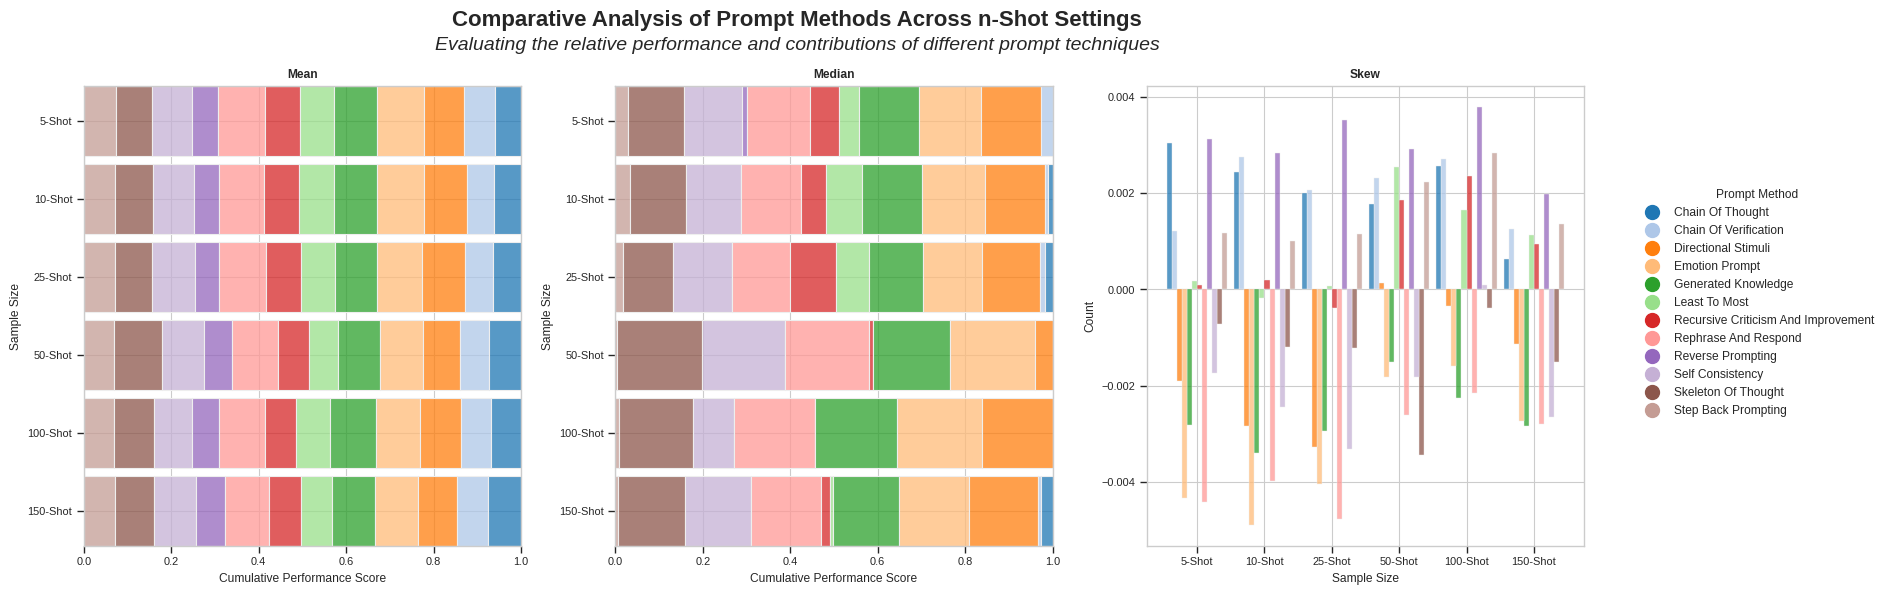

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming 'df' is your initial DataFrame
# Group the data and calculate the statistics
df_copy = df.copy()

expected_amount = 180
grouped_data_mean = df_copy.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].mean().apply(lambda x: x / expected_amount).reset_index()
grouped_data_median = df_copy.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].median().apply(lambda x: x / expected_amount).reset_index()
grouped_data_skew = df_copy.groupby(['prompt_method', 'sample_size'])['extracted_data_len'].skew().apply(lambda x: x / expected_amount).reset_index()

# Define the order of 'sample_size' and 'prompt_method'
sample_size_order = ['rs_size_5', 'rs_size_10', 'rs_size_25', 'rs_size_50', 'rs_size_100', 'rs_size_150']
prompt_method_order = sorted(grouped_data_mean['prompt_method'].unique())  # Sorted alphabetically

# Convert 'sample_size' to a categorical type with a defined order in all DataFrames
dataframes = [grouped_data_mean, grouped_data_median, grouped_data_skew]
for df_copy in dataframes:
    df_copy['sample_size'] = pd.Categorical(df_copy['sample_size'], categories=sample_size_order, ordered=True)

# Create a figure and array of subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
fig.suptitle('Comparative Analysis of Prompt Methods Across n-Shot Settings', fontweight='bold', fontsize=16, y=0.98)

# Add description below the title
fig.text(0.5, 0.92, "Evaluating the relative performance and contributions of different prompt techniques", 
         ha='center', va='center', fontsize=14, style='italic')

# Color palette
palette = sns.color_palette('tab20', len(prompt_method_order))

# Function to format x-tick labels
def format_yticks(ax):
    ax.set_yticklabels([f"{x.get_text().split('_')[-1]}-Shot" for x in ax.get_yticklabels()])
    ax.tick_params(axis='y', rotation=0)

# Function to format x-tick labels
def format_xticks(ax):
    ax.set_xticklabels([f"{x.get_text().split('_')[-1]}-Shot" for x in ax.get_xticklabels()])
    ax.tick_params(axis='x', rotation=0)

# Plot each statistic in its respective subplot
sns.histplot(data=grouped_data_mean, y='sample_size', weights='extracted_data_len', hue='prompt_method',
             hue_order=prompt_method_order, multiple='fill', shrink=0.90, palette=palette, ax=ax1)
ax1.set_title('Mean', fontweight='bold')
ax1.set_ylabel('Sample Size')
ax1.set_xlabel('Cumulative Performance Score')
ax1.set_xlim([0,1])
ax1.get_legend().remove()
format_yticks(ax1)

sns.histplot(data=grouped_data_median, y='sample_size', weights='extracted_data_len', hue='prompt_method',
             hue_order=prompt_method_order, multiple='fill', shrink=0.90, palette=palette, ax=ax2)
ax2.set_title('Median', fontweight='bold')
ax2.set_ylabel('Sample Size')
ax2.set_xlabel('Cumulative Performance Score')
ax2.set_xlim([0,1])
ax2.get_legend().remove()
format_yticks(ax2)

sns.histplot(data=grouped_data_skew, x='sample_size', weights='extracted_data_len', hue='prompt_method',
             hue_order=prompt_method_order, multiple='dodge', shrink=0.90, palette=palette, ax=ax3)
ax3.set_title('Skew', fontweight='bold')
ax3.set_xlabel('Sample Size')
ax3.get_legend().remove()
format_xticks(ax3)

# Function to format prompt method names
def format_prompt_method(name):
    return ' '.join(word.capitalize() for word in name.split('_'))

# Create a custom legend with formatted prompt method names
legend_handles = [plt.Line2D([0], [0], color=palette[i], marker='o', linestyle='', markersize=10, 
                             label=format_prompt_method(label)) 
                  for i, label in enumerate(prompt_method_order)]
fig.legend(handles=legend_handles, title='Prompt Method', loc='upper right', 
           bbox_to_anchor=(1.18, 0.70), fontsize='medium')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust the rect to fit the figure title and the legend

plt.savefig('./images/stacked_bar_mean_median_max_extracted_rows.jpg', dpi=300, bbox_inches='tight')
plt.show()

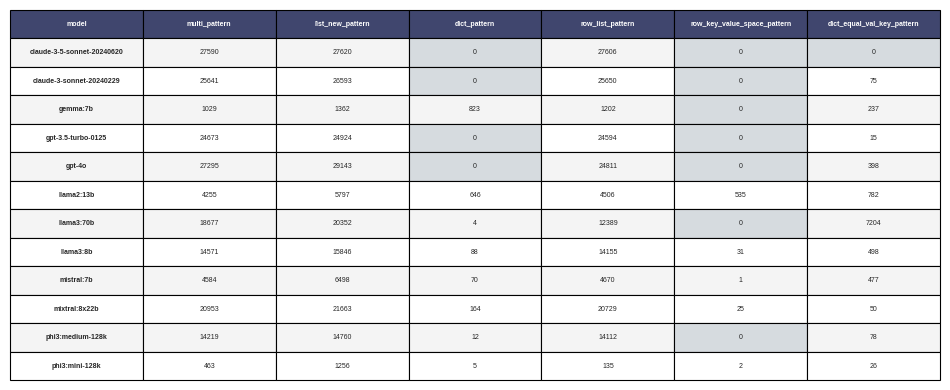

In [8]:
# Custom aggregation function to sum dictionary values
def sum_dicts(series):
    result = {}
    for d in series:
        for key, val in d.items():
            if key in result:
                result[key] += val
            else:
                result[key] = val
    return result

# Group by 'model' and aggregate using custom function
result = df.groupby('model')['regex_counts'].agg(sum_dicts).reset_index()

regex_cols = ['multi_pattern', 'list_new_pattern', 'dict_pattern', 
              'row_list_pattern', 'row_key_value_space_pattern', 'dict_equal_val_key_pattern']

# Initialize a new DataFrame
df_regex = pd.DataFrame(columns=['model'] + regex_cols)

# Populate the new DataFrame
rows_list = []
for index, row in result.iterrows():
    # Start by setting the model
    new_row = {'model': row['model']}
    
    # Retrieve the regex_counts dictionary from the result DataFrame
    regex_counts = row['regex_counts']
    
    # Loop through each expected regex column to set its value
    for col in regex_cols:
        new_row[col] = regex_counts.get(col, 0)  # Use .get to avoid KeyError if key is missing
    
    # Add new_row to rows_list to append later
    rows_list.append(new_row)

# Create a DataFrame from rows_list and concatenate with the initial empty DataFrame
df_regex = pd.concat([df_regex, pd.DataFrame(rows_list)], ignore_index=True)

df_regex

# Plotting setup
# Adjust the figure size dynamically based on the number of rows
fig_height = len(df_regex) * 0.02 + 0.5  # 0.02 per row plus some margin
fig, ax = plt.subplots(figsize=(12, fig_height))  # Use dynamic height
ax.axis('off')  # Hide the axis

# Create the table
the_table = ax.table(cellText=df_regex.values, colLabels=df_regex.columns, loc='center', cellLoc='center', colColours=["#f2f2f2"] * len(df_regex.columns))

# Customize cell properties for aesthetics
for (i, j), cell in the_table.get_celld().items():
    text = cell.get_text().get_text()  # Get cell text
    if i == 0:
        cell.set_text_props(weight='bold', fontsize=12)  # Bold headers
        cell.set_facecolor('#40466e')  # Darker color for header
        cell.set_text_props(color='white')  # White text for contrast
    else:
        if j == 0:  # First column (model names)
            cell.set_text_props(weight='bold')  # Make model names bold
        if text == '0':  # Check if cell text is '0'
            cell.set_facecolor('#d6dbdf')  # Set dark grey for zero values
        else:
            cell.set_facecolor('#f4f4f4' if i % 2 else 'white')  # Alternating colors for non-zero rows
    cell.set_height(0.5)  # Increased height for all cells

# Optionally, save the figure
plt.savefig('./images/table_regex_performance.jpg', dpi=300, bbox_inches='tight')
plt.show()